## Business Understanding
### Objective: Build an NLP model that predicts the sentiment (positive, negative, or neutral) of Tweets about Apple and Google products.

### Key Questions
- What is the distribution of sentiments in the dataset?
- How do Apple and Google product-related Tweets differ in sentiment?
- Can we improve customer understanding of the product sentiment trends?

## Data Description
Dataset Overview:
The dataset contains over 9,000 Tweets with human-rated sentiment labels (positive, negative, or neutral).


In [120]:
# importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

## Data Understanding

In [121]:
# Loading the dataset

text_df = pd.read_csv('../data_file/tweet_sentiments.csv', encoding='ISO-8859-1')


In [122]:
# Preview the dataset
text_df.head(10)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


- The DataFrame contains 3 columns, one that bears the tweet, the product, and the sentiment named tweet_text, emotion_in_tweet_is_directed_at, and is_there_an_emotion_directed_at_a_brand_or_product respectively

In [123]:
# renaming the columns to shorter titles
text_df = text_df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment',
    'tweet_text':'tweets'
    })


In [124]:
#Checking basic info on dataset
text_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


- The DataFrame has 9093 entries, and 3 columns all which are of the 'Object' datatype. 2 of the columns, product and tweets have missing values

In [125]:
# Checking for the number of missing values
text_df.isnull().sum()


tweets          1
product      5802
sentiment       0
dtype: int64

- The tweets column has 1 missing value while the product column has 5802.

In [126]:
# Checking the distribution of sentiments
text_df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

- Most tweets (5,389) do not express any emotion toward a brand or product, while 2,978 tweets convey positive emotion, and 570 express negative emotion. A smaller number of tweets (156) were unclear or ambiguous in sentiment

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

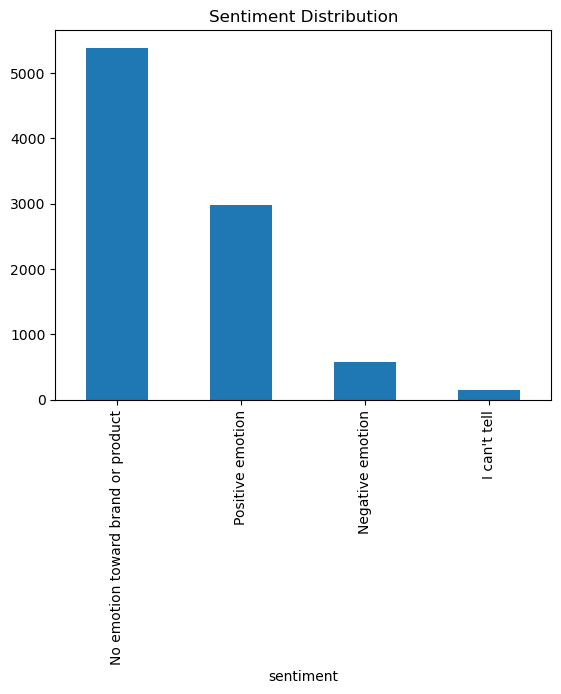

In [127]:
# plotting the distribution of sentiment classes
text_df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

## Data Preparation

#### I will utilize this section to;
- Remove any duplicates.
- Handle missing values.
- Normalize text (convert to lowercase, remove URLs, mentions (@), hashtags (#), numbers, special characters, etc.
- Remove stopwords which don't add significant value for sentiment analysis).
- Apply tokenization and lemmatization.


In [128]:
# checking for duplicates

text_df.duplicated().value_counts()

False    9071
True       22
Name: count, dtype: int64

-  There are 22 duplicated rows (True), while the vast majority of the data (9,071 rows) are unique (False). I will drop the duplicates

In [129]:
# dropping the duplicates
text_df =text_df.drop_duplicates()
text_df.duplicated().value_counts()

False    9071
Name: count, dtype: int64

In [130]:
# Handling Missing Values
text_df = text_df.dropna(subset=['tweets']) # Drop the 1 missing value in tweets column
text_df.isna().sum()

tweets          0
product      5788
sentiment       0
dtype: int64

In [131]:
#Drop the product column in it's entirety

text_df_modified = text_df.drop(columns = 'product')
text_df_modified.head()

,tweets,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [134]:
#validating that there are no missing values 
text_df_modified.isna().sum()

tweets       0
sentiment    0
dtype: int64

#### Text Normalization

In [140]:
#importing relevant libraries for text preprocessing 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [141]:

# Define a function to clean tweets
def clean_tweets (text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters and numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    
    return ' '.join(words)
    



In [142]:
text_df_modified['cleanTweets'] = text_df_modified['tweets'].apply(clean_tweets)
text_df_modified.head()

,tweets,sentiment,cleanTweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff fri sxsw marissa mayer google tim ...


- The `cleanTweets` column in the dataFrame now containes preprocessed tweets which have been lowercased, lemmatized, tokenized, and stripped off of mentions, URLs, special characters, and punctuation 

#### Visualizing Top 10 words for every sentiment 

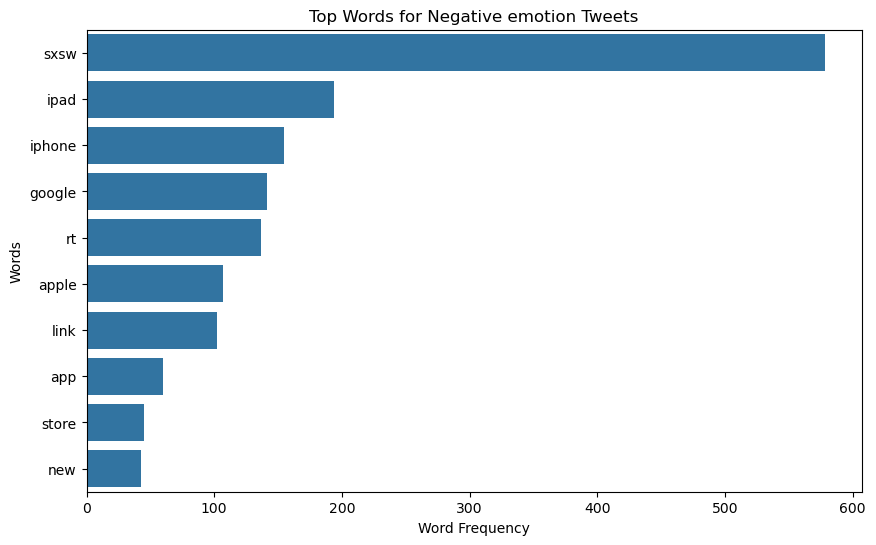

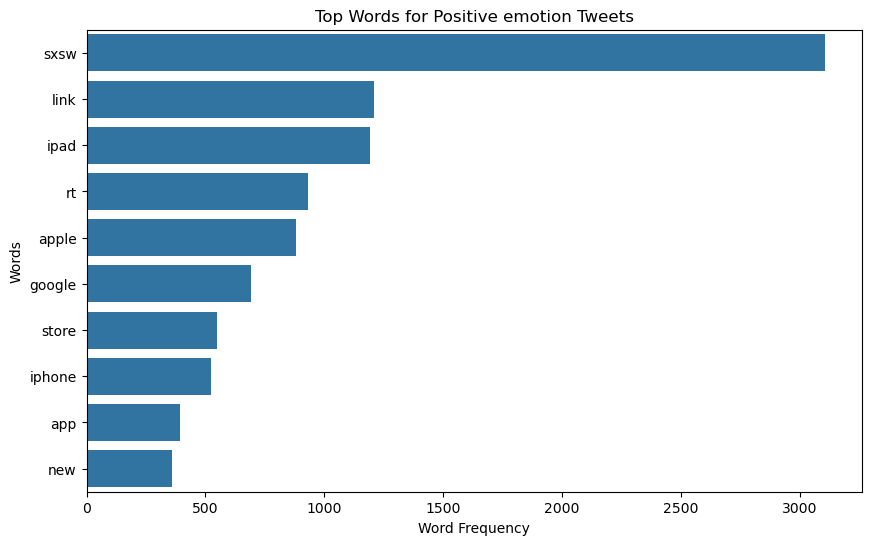

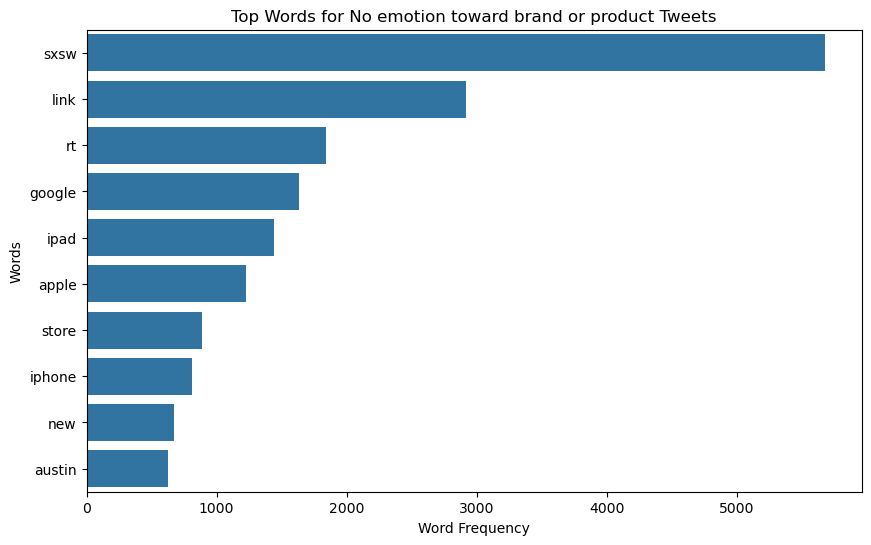

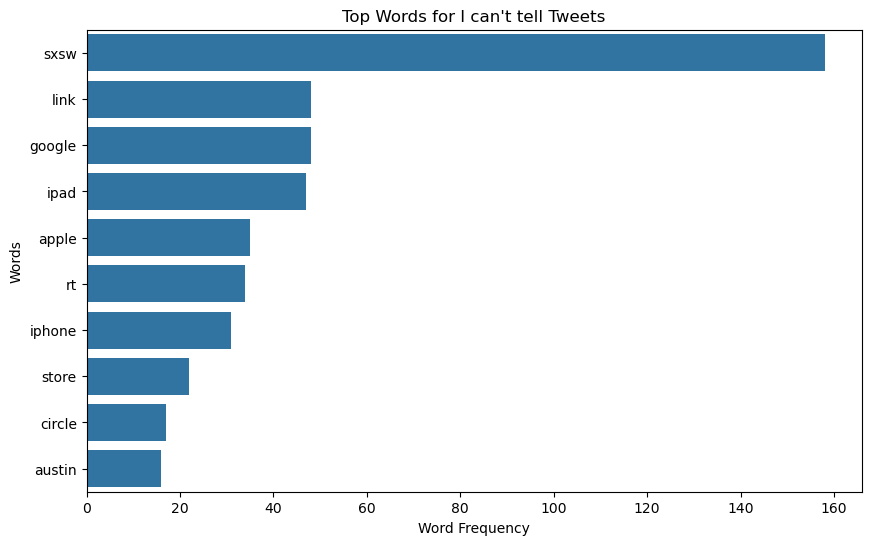

In [152]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Generate bar plots for each sentiment class
for sentiment in text_df_modified['sentiment'].unique():
    # Filter the DataFrame by sentiment
    sentiment_df = text_df_modified[text_df_modified['sentiment'] == sentiment]
    
    # Create a document-term matrix
    X = vectorizer.fit_transform(sentiment_df['cleanTweets'])
    
    # Sum the occurrences of each word
    word_counts = X.toarray().sum(axis=0)
    
    # Get the words and their respective counts
    words = vectorizer.get_feature_names_out()
    word_freq = dict(zip(words, word_counts))
    
    # Convert to DataFrame for easier plotting
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'count'])
    
    # Sort the DataFrame by count
    word_freq_df = word_freq_df.sort_values(by='count', ascending=False).head(10)  # Top 10 words
    
    # Plot the top 10 words as a bar plot
   
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=word_freq_df)
    plt.title(f'Top Words for {sentiment} Tweets')
    plt.xlabel('Word Frequency')
    plt.ylabel('Words')
    plt.show()


### Vectorization
This section will utilize the TF-IDF Vectorizer to convert the cleaned text into numerical features 